In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
df = pd.read_csv("/Users/parth/Hack o hire/github_repo/Datasets/synthetic_logs.csv")

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")  # Ensure chronological order

# Normalize response time
scaler = MinMaxScaler()
df["response_time"] = scaler.fit_transform(df[["response_time"]])

# Encode categorical features
encoder = LabelEncoder()
df["method"] = encoder.fit_transform(df["method"])
df["endpoint"] = encoder.fit_transform(df["endpoint"])
df["status_code"] = encoder.fit_transform(df["status_code"])

# Select features
features = ["method", "endpoint", "status_code", "size", "response_time"]
data = df[features].values

# Define sequence length
SEQ_LENGTH = 50  # Number of previous logs to consider

# Prepare sequences for LSTM
X, y = [], []
for i in range(len(data) - SEQ_LENGTH):
    X.append(data[i:i + SEQ_LENGTH])
    y.append(data[i + SEQ_LENGTH, -1])  # Predict response time

X, y = np.array(X), np.array(y)

# Split into training and testing sets
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]


Epoch 1/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0866
Epoch 1: val_loss improved from inf to 0.07117, saving model to best_lstm_model.keras
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.0866 - val_loss: 0.0712 - learning_rate: 0.0010
Epoch 2/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0761
Epoch 2: val_loss did not improve from 0.07117
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.0761 - val_loss: 0.0714 - learning_rate: 0.0010
Epoch 3/50
1248/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0753
Epoch 3: val_loss did not improve from 0.07117
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.0753 - val_loss: 0.0715 - learning_rate: 0.0010
Epoch 4/50
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0762
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from 0.07117
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0762 - val_loss: 0.0713 - learning_rate: 0.0010
Epoc

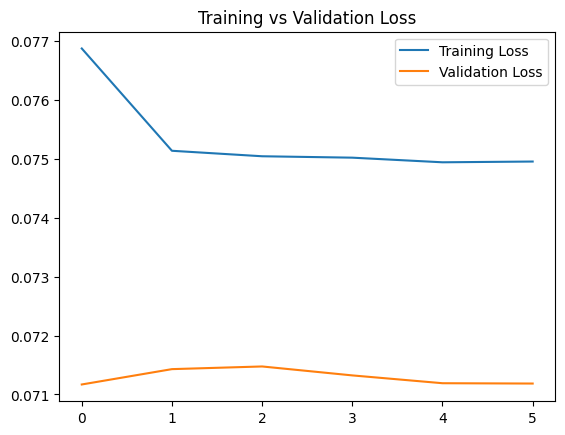

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)  # Predicting response time
])

# Compile model
model.compile(optimizer="adam", loss="mse")

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)

# Reduce LR when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1
)

# Optional: Save best model based on validation loss
checkpoint = ModelCheckpoint(
    "best_lstm_model.keras", monitor="val_loss", save_best_only=True, verbose=1
)

# Train model with early stopping & learning rate scheduler
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Scale y values
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/var/folders/s0/bydqpv9j4kjb57ft3v_pyl6r0000gn/T/ipykernel_12003/2855217344.py:30: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(anomalies_zoom, y_test_zoom[anomalies_zoom], color='red', label="Anomalies", marker='x', s=50, edgecolors='black')


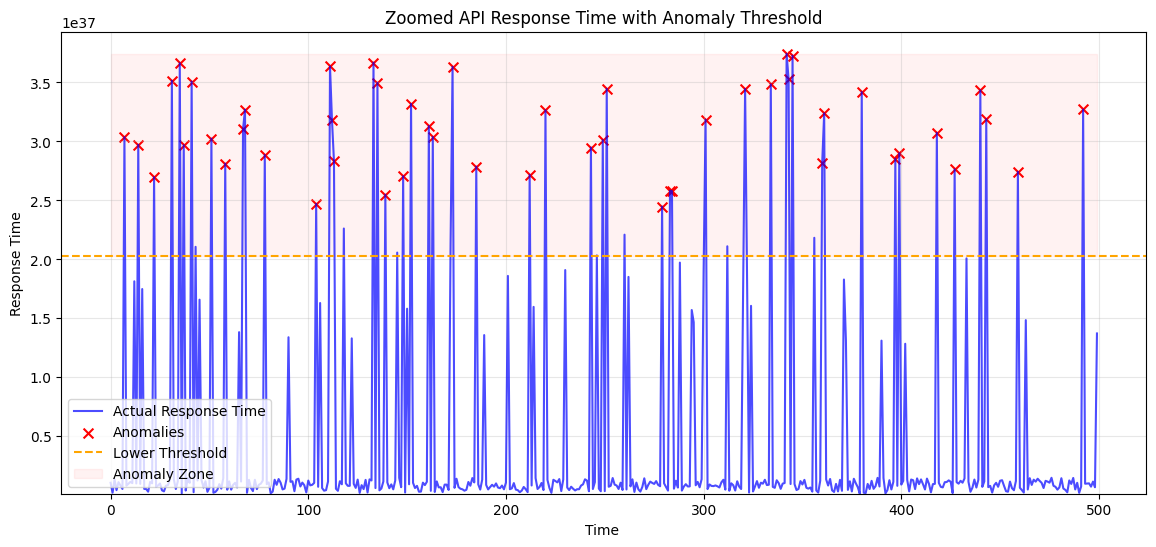

In [15]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))  # Convert back to original scale
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))



import numpy as np
import matplotlib.pyplot as plt

# Detect anomalies with a lower threshold
error = np.abs(y_test - y_pred)
threshold = np.percentile(error, 90)  # Lowered from 98th to 90th percentile
anomalies = np.where(error > threshold)[0]

# Decrease dynamic threshold (mean + 1.5 * std deviation)
dyn_threshold = np.mean(y_test) + 1.5 * np.std(y_test)  # Lowered from 3*std

# Zoom into last 500 points for smoother visualization
zoom_range = -500  
y_test_zoom = y_test[zoom_range:]
y_pred_zoom = y_pred[zoom_range:]
anomalies_zoom = anomalies[anomalies >= len(y_test) + zoom_range] - (len(y_test) + zoom_range)

plt.figure(figsize=(14, 6))
plt.plot(y_test_zoom, label="Actual Response Time", color='blue', alpha=0.7)
#plt.plot(y_pred_zoom, label="Predicted Response Time", color='green', linestyle='dashed', alpha=0.7)

# Highlight anomaly points
plt.scatter(anomalies_zoom, y_test_zoom[anomalies_zoom], color='red', label="Anomalies", marker='x', s=50, edgecolors='black')

# Lower threshold line
plt.axhline(y=dyn_threshold, color='orange', linestyle='--', label="Lower Threshold")

# Adjust Y-axis limits dynamically
plt.ylim(min(y_test_zoom) * 0.95, max(y_test_zoom) * 1.05)

# Highlight anomaly region
plt.fill_between(range(len(y_test_zoom)), dyn_threshold, max(y_test_zoom), color='red', alpha=0.05, label="Anomaly Zone")

plt.legend()
plt.title("Zoomed API Response Time with Anomaly Threshold")
plt.xlabel("Time ")
plt.ylabel("Response Time")
plt.grid(alpha=0.3)
plt.show()
